In [77]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split, KFold, GridSearchCV


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from IPython.display import Image

from scipy.stats import mode
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [78]:
file = 'for_cours.xlsx'

Описание датасета.
Это набор лабораторных данных в ходе проспективного медицинского наблюдения. Исход наблюдения предствлен ввиде положительного или отрицательного исхода.
Точки наблюдения: 
zero  - до начала вмешательства;
transfer - вмешательство;
2-3 day - 2-3 день нблюдения, после проводимого вмешательства;
8 day- 8 день нблюдения, после проводимого вмешательства.
Показатели тестов: T, Vi, Vs, D, CS, Dd, HDF.
Тип вводимых лекартсвенных препаратов также имеет соответствующий шифр - drug (2 ; 3 ; 4).
Целевая или таргетная переменная - result(1-no, 0- yes).

In [79]:
df = pd.ExcelFile(file)
print(df.sheet_names)

['Крио']


In [80]:
df = df.parse('Крио')

In [81]:
df.tail()

,id patient,drug,result,T_0d,Vi_0d,Vs_0d,D_0d,CS_0d,HDF_tr,Dd_tr,...,Vs_2d,D_2d,CS_2d,HDF_8d,Dd_8d,T_8d,Vi_8d,Vs_8d,D_8d,CS_8d
52,YAAA,3,0,0.958333,48.89,25.40,23410.223433,1080.29,7.0,370.0,...,27.88,27455.272727,1117.80,9.0,442.0,1.05,53.38,31.27,25992.067227,1197.44
53,CHMA,3,0,0.950000,48.73,28.15,30166.832432,1113.74,7.0,160.0,...,27.82,25904.851064,1130.20,NaN,NaN,1.15,48.41,30.76,27293.247312,1104.38
54,ZLN2,3,0,0.850000,43.97,26.45,22964.000000,1025.28,NaN,NaN,...,27.54,29407.910364,1104.74,5.0,246.0,0.85,59.35,30.78,23179.000000,1208.28
55,KNA,3,0,0.850000,45.06,25.34,19731.000000,1009.44,5.0,229.0,...,27.79,24465.940701,1082.02,5.0,391.0,0.75,54.56,31.52,26898.813187,1228.14
56,MSV,3,0,0.950000,44.78,24.09,23527.000000,987.56,9.0,149.0,...,29.08,25998.891967,1090.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df.describe()

,drug,result,T_0d,Vi_0d,Vs_0d,D_0d,CS_0d,HDF_tr,Dd_tr,T_tr,...,Vs_2d,D_2d,CS_2d,HDF_8d,Dd_8d,T_8d,Vi_8d,Vs_8d,D_8d,CS_8d
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,49.000000,49.000000,57.000000,...,57.000000,57.000000,57.000000,41.000000,41.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,2.736842,0.368421,0.922398,49.587719,27.894912,23613.236855,1101.481228,5.979592,316.163265,0.946784,...,28.649123,25108.702418,1126.345789,6.121951,282.731707,0.933000,51.341000,29.715800,25012.510284,1153.390600
std,0.518456,0.486664,0.123790,4.526695,2.951215,3037.324483,88.343123,1.547711,458.206028,0.147774,...,3.118425,3456.185099,86.428586,1.939009,264.912913,0.156365,4.820643,4.356647,2922.509476,113.954167
min,2.000000,0.000000,0.750000,41.200000,23.390000,16595.000000,923.180000,4.000000,69.000000,0.750000,...,21.830000,17106.237467,944.750000,4.000000,105.000000,0.750000,39.740000,20.990000,17438.000000,911.810000
25%,2.000000,0.000000,0.850000,46.370000,25.340000,21605.000000,1032.890000,5.000000,145.000000,0.850000,...,27.230000,23234.042553,1084.030000,5.000000,149.000000,0.775000,48.445000,27.277500,23295.095101,1091.897500
50%,3.000000,0.000000,0.950000,48.890000,27.820000,23410.223433,1104.040000,6.000000,193.000000,0.950000,...,28.330000,25721.071225,1121.020000,5.000000,206.000000,0.950000,50.820000,29.070000,25310.000000,1140.930000
75%,3.000000,1.000000,0.950000,52.010000,29.720000,25449.000000,1159.650000,7.000000,328.000000,1.050000,...,30.390000,27280.566757,1170.260000,7.000000,307.000000,1.050000,54.560000,31.715000,26956.703297,1228.140000
max,4.000000,1.000000,1.250000,66.100000,35.670000,30166.832432,1355.510000,9.000000,3148.000000,1.350000,...,39.830000,31897.000000,1474.240000,11.000000,1706.000000,1.250000,64.480000,39.980000,30981.000000,1386.870000


отбор числовых колонок

In [83]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['drug' 'result' 'T_0d' 'Vi_0d' 'Vs_0d' 'D_0d' 'CS_0d' 'HDF_tr' 'Dd_tr'
 'T_tr' 'Vi_tr' 'Vs_tr' 'D_tr' 'CS_tr' 'HDF_2d' 'Dd_2d' 'T_2d' 'Vi_2d'
 'Vs_2d' 'D_2d' 'CS_2d' 'HDF_8d' 'Dd_8d' 'T_8d' 'Vi_8d' 'Vs_8d' 'D_8d'
 'CS_8d']


отбор нечисловых колонок

In [84]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['id patient']


Тепловая карта пропущенных значений.

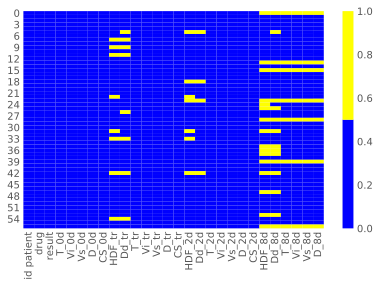

In [85]:
cols = df.columns[:28]
colours = ['blue', 'yellow'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

можно составить список долей(%) отсутствующих записей для каждого признака

In [86]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id patient - 0.0%
drug - 0.0%
result - 0.0%
T_0d - 0.0%
Vi_0d - 0.0%
Vs_0d - 0.0%
D_0d - 0.0%
CS_0d - 0.0%
HDF_tr - 14.0%
Dd_tr - 14.0%
T_tr - 0.0%
Vi_tr - 0.0%
Vs_tr - 0.0%
D_tr - 0.0%
CS_tr - 0.0%
HDF_2d - 12.0%
Dd_2d - 7.0%
T_2d - 0.0%
Vi_2d - 0.0%
Vs_2d - 0.0%
D_2d - 0.0%
CS_2d - 0.0%
HDF_8d - 28.0%
Dd_8d - 28.0%
T_8d - 12.0%
Vi_8d - 12.0%
Vs_8d - 12.0%
D_8d - 12.0%
CS_8d - 12.0%


Стратегию принудительного заполнения медианой  пустых значений можно применить сразу для всех числовых признаков:

In [87]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        med = df[col].median()
        df[col] = df[col].fillna(med)

imputing missing values for: HDF_tr
imputing missing values for: Dd_tr
imputing missing values for: HDF_2d
imputing missing values for: Dd_2d
imputing missing values for: HDF_8d
imputing missing values for: Dd_8d
imputing missing values for: T_8d
imputing missing values for: Vi_8d
imputing missing values for: Vs_8d
imputing missing values for: D_8d
imputing missing values for: CS_8d


Проверим заполненость пустых значений в  "базе"

In [88]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id patient - 0.0%
drug - 0.0%
result - 0.0%
T_0d - 0.0%
Vi_0d - 0.0%
Vs_0d - 0.0%
D_0d - 0.0%
CS_0d - 0.0%
HDF_tr - 0.0%
Dd_tr - 0.0%
T_tr - 0.0%
Vi_tr - 0.0%
Vs_tr - 0.0%
D_tr - 0.0%
CS_tr - 0.0%
HDF_2d - 0.0%
Dd_2d - 0.0%
T_2d - 0.0%
Vi_2d - 0.0%
Vs_2d - 0.0%
D_2d - 0.0%
CS_2d - 0.0%
HDF_8d - 0.0%
Dd_8d - 0.0%
T_8d - 0.0%
Vi_8d - 0.0%
Vs_8d - 0.0%
D_8d - 0.0%
CS_8d - 0.0%
HDF_tr_ismissing - 0.0%
Dd_tr_ismissing - 0.0%
HDF_2d_ismissing - 0.0%
Dd_2d_ismissing - 0.0%
HDF_8d_ismissing - 0.0%
Dd_8d_ismissing - 0.0%
T_8d_ismissing - 0.0%
Vi_8d_ismissing - 0.0%
Vs_8d_ismissing - 0.0%
D_8d_ismissing - 0.0%
CS_8d_ismissing - 0.0%


Составим список признаков, у которых более 95% строк содержат одно и то же значение.

In [89]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Графически представим данные наших наблюдений для каждого параметра во времени.

Построить коробчатую диаграмму для каждого параметра в периоде наблюдения. Нанести линии рефересных значений. Визуально оценить выбросы по данным.

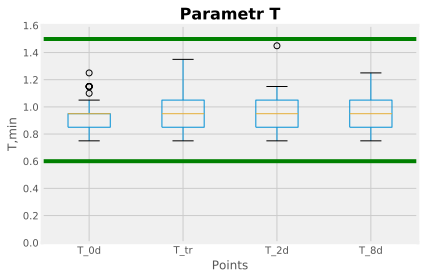

In [90]:
df.boxplot(column=['T_0d','T_tr', 'T_2d','T_8d'])  
plt.ylim(0,1.6)
plt.title('Parametr T', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('T,min',fontsize=12)
plt.axhline(y=0.6, color = 'green', linestyle = '-')
plt.axhline(y=1.5, color = 'green', linestyle = '-')

Аналогично делаем для других показателей.

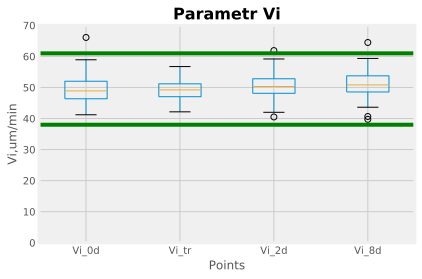

In [91]:
df.boxplot(column=['Vi_0d','Vi_tr', 'Vi_2d','Vi_8d'])  
plt.ylim(0,70)
plt.title('Parametr Vi', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('Vi,um/min',fontsize=12)
plt.axhline(y=38, color = 'green', linestyle = '-')
plt.axhline(y=61, color = 'green', linestyle = '-')

Параметр Vs

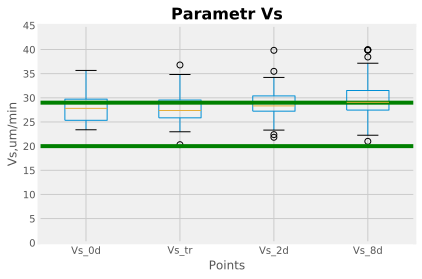

In [92]:
df.boxplot(column=['Vs_0d','Vs_tr', 'Vs_2d','Vs_8d'])  
plt.ylim(0,45)
plt.title('Parametr Vs', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('Vs,um/min',fontsize=12)
plt.axhline(y=20, color = 'green', linestyle = '-')
plt.axhline(y=29, color = 'green', linestyle = '-')

параметр Vs сдвинут вправую сторону. Необходимо оценить наблюдаемые точки ('Vs_tr', 'Vs_2d','Vs_8d') на "выбросы"

Параметр D.

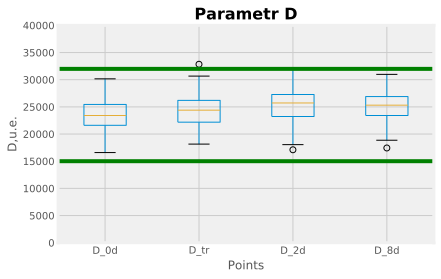

In [93]:
df.boxplot(column=['D_0d','D_tr', 'D_2d','D_8d'])  
plt.ylim(0,40000)
plt.title('Parametr D', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('D,u.e.',fontsize=12)
plt.axhline(y=15000, color = 'green', linestyle = '-')
plt.axhline(y=32000, color = 'green', linestyle = '-')

Необходимо оценить наблюдаемые точки ('D_tr', 'D_2d','D_8d') на "выбросы"

Параметр CS

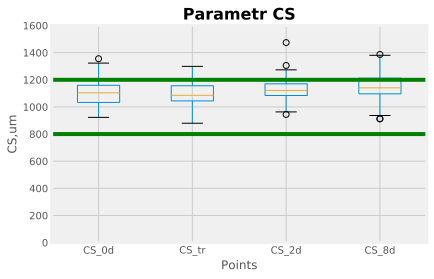

In [94]:
df.boxplot(column=['CS_0d','CS_tr', 'CS_2d','CS_8d'])  
plt.ylim(0,1600)
plt.title('Parametr CS', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('CS,um',fontsize=12)
plt.axhline(y=800, color = 'green', linestyle = '-')
plt.axhline(y=1200, color = 'green', linestyle = '-')

Необходимо оценить наблюдаемые точки ('CS_0d','CS_2d','CS_8d') на "выбросы"

 Парметр HDF

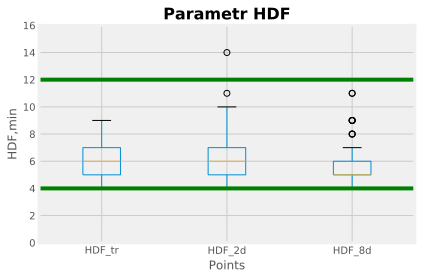

In [95]:
df.boxplot(column=['HDF_tr', 'HDF_2d','HDF_8d'])  
plt.ylim(0,16)
plt.title('Parametr HDF', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('HDF,min',fontsize=12)
plt.axhline(y=4, color = 'green', linestyle = '-')
plt.axhline(y=12, color = 'green', linestyle = '-')

Необходимо оценить наблюдаемые точки ('HDF_2d','HDF_8d') на "выбросы"

Параметр Dd

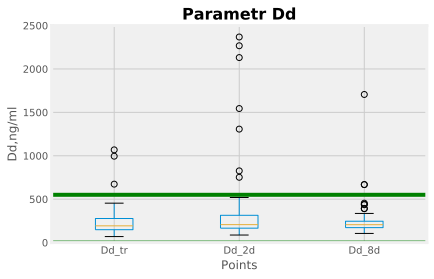

In [96]:
df.boxplot(column=['Dd_tr', 'Dd_2d','Dd_8d'])  
plt.ylim(0,2500)
plt.title('Parametr Dd', fontsize=16, fontweight="bold")
plt.xlabel('Points',fontsize=12)
plt.ylabel('Dd,ng/ml',fontsize=12)
plt.axhline(y=0, color = 'green', linestyle = '-')
plt.axhline(y=550, color = 'green', linestyle = '-')

Необходимо оценить наблюдаемые точки ('Dd_tr', 'Dd_2d','Dd_8d') на "выбросы"

Функция для "выбросов"

Создадим функцию для того, чтобы избавиться от выбросов, алгоритм единый, поэтому смысла писать практически одно и то же нет

In [97]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    if col != ('result' or 'drug'):
        val_max = np.quantile(df[col], q=0.975)
        val_min = np.quantile(df[col], q=0.025)
        condition = (df[col] > val_max) | (df[col] < val_min)
        df.loc[condition, col] = df[col].median()        
df.describe()

,drug,result,T_0d,Vi_0d,Vs_0d,D_0d,CS_0d,HDF_tr,Dd_tr,T_tr,...,Vs_2d,D_2d,CS_2d,HDF_8d,Dd_8d,T_8d,Vi_8d,Vs_8d,D_8d,CS_8d
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,2.701754,0.368421,0.917135,49.377719,27.797544,23614.729159,1099.008070,5.982456,235.526316,0.934357,...,28.540351,25180.297012,1122.768596,5.596491,238.315789,0.924561,51.260526,29.706491,25108.959441,1151.363333
std,0.461555,0.486664,0.115728,3.402484,2.493673,2475.700620,69.410278,1.432919,146.134002,0.130552,...,2.263191,2885.220068,60.499439,1.399740,113.373617,0.133337,3.421700,3.527880,2144.101082,86.107326
min,2.000000,0.000000,0.750000,42.080000,23.880000,18801.000000,980.660000,4.000000,112.000000,0.750000,...,23.320000,18824.112676,995.910000,4.000000,119.000000,0.750000,43.630000,22.670000,19283.587879,936.600000
25%,2.000000,0.000000,0.850000,46.620000,25.540000,22145.565217,1036.300000,5.000000,149.000000,0.850000,...,27.380000,23373.217391,1088.200000,5.000000,197.000000,0.850000,49.320000,27.540000,23594.724324,1100.530000
50%,3.000000,0.000000,0.950000,48.890000,27.820000,23410.223433,1104.040000,6.000000,193.000000,0.950000,...,28.330000,25721.071225,1121.020000,5.000000,206.000000,0.950000,50.820000,29.070000,25310.000000,1140.930000
75%,3.000000,1.000000,0.950000,51.380000,29.450000,25304.000000,1144.610000,7.000000,250.000000,0.950000,...,30.230000,27094.769231,1159.060000,6.000000,245.000000,0.950000,53.330000,31.460000,26760.000000,1206.340000
max,3.000000,1.000000,1.150000,57.130000,34.150000,29025.000000,1278.730000,9.000000,995.000000,1.250000,...,34.220000,30446.505190,1273.310000,9.000000,668.000000,1.200000,58.970000,39.870000,29233.271233,1379.930000


Далее строим диаграмму для параметра "result". 

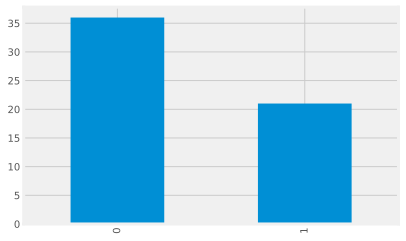

In [98]:
result_info = pd.Series(df['result'].value_counts())
result_info.plot(kind = 'bar')
plt.show()

Переходим к построение модели. 1)Выбора данных. 2) Выбора целевой переменной. 3) Разбиение на train и test выборки. 4) Обучение моделей. Далее будет представлена лучшая модель для этих данных, полученная на настоящий момент.

In [99]:
df.columns.tolist()

['id patient',
 'drug',
 'result',
 'T_0d',
 'Vi_0d',
 'Vs_0d',
 'D_0d',
 'CS_0d',
 'HDF_tr',
 'Dd_tr',
 'T_tr',
 'Vi_tr',
 'Vs_tr',
 'D_tr',
 'CS_tr',
 'HDF_2d',
 'Dd_2d',
 'T_2d',
 'Vi_2d',
 'Vs_2d',
 'D_2d',
 'CS_2d',
 'HDF_8d',
 'Dd_8d',
 'T_8d',
 'Vi_8d',
 'Vs_8d',
 'D_8d',
 'CS_8d',
 'HDF_tr_ismissing',
 'Dd_tr_ismissing',
 'HDF_2d_ismissing',
 'Dd_2d_ismissing',
 'HDF_8d_ismissing',
 'Dd_8d_ismissing',
 'T_8d_ismissing',
 'Vi_8d_ismissing',
 'Vs_8d_ismissing',
 'D_8d_ismissing',
 'CS_8d_ismissing']

In [100]:
feature = ['drug', 'T_0d', 'Vi_0d', 'Vs_0d', 'D_0d', 'CS_0d', 'HDF_tr', 'Dd_tr', 'T_tr', 'Vi_tr', 'Vs_tr', 'D_tr', 'CS_tr',
             'HDF_2d', 'Dd_2d', 'T_2d', 'Vi_2d', 'Vs_2d', 'D_2d','CS_2d', 'HDF_8d', 'Dd_8d', 'T_8d', 'Vi_8d', 'Vs_8d', 'D_8d', 'CS_8d']

target = 'result'

In [101]:
df = df[feature + [target]]
df.head()

,drug,T_0d,Vi_0d,Vs_0d,D_0d,CS_0d,HDF_tr,Dd_tr,T_tr,Vi_tr,...,D_2d,CS_2d,HDF_8d,Dd_8d,T_8d,Vi_8d,Vs_8d,D_8d,CS_8d,result
0,2.0,0.85,46.62,27.82,20496.688172,980.66,7.0,673.0,0.95,49.21,...,21335.241192,1121.02,5.0,206.0,0.95,50.82,29.07,25310.000000,1140.93,1
1,2.0,0.85,53.85,29.54,23224.810959,1162.02,6.0,176.0,0.95,44.77,...,24007.478261,1196.18,5.0,391.0,0.75,54.56,31.52,26898.813187,1228.14,1
2,3.0,0.95,49.98,28.65,26130.000000,1101.76,7.0,449.0,0.75,52.66,...,26140.640884,1150.13,6.0,336.0,0.75,47.56,27.25,28175.000000,1078.92,1
3,3.0,1.05,50.42,28.79,28053.000000,1126.07,6.0,204.0,0.75,50.72,...,25735.730337,1135.34,9.0,252.0,0.75,55.87,38.45,24311.000000,1140.93,1
4,3.0,0.85,48.19,25.12,27799.700000,1036.30,7.0,199.0,0.75,49.21,...,25067.816712,1069.79,7.0,199.0,0.85,55.83,32.24,24554.000000,1240.20,1


перед применением моделей применим стандартизацию признаков. 

Будем использовать StandardScaler.

In [102]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature])

In [103]:
stand_features

array([[-1.53392998, -0.58526339, -0.8177064 , ..., -0.18202122,
         0.09459798, -0.12224367],
       [-1.53392998, -0.58526339,  1.32610036, ...,  0.51862001,
         0.8422009 ,  0.89956503],
       [ 0.65192024,  0.28651396,  0.17858554, ..., -0.70249757,
         1.44270007, -0.8487929 ],
       ...,
       [ 0.65192024, -0.58526339, -1.60347237, ...,  0.30699776,
        -0.90812648,  0.66687244],
       [ 0.65192024, -0.58526339, -1.28027052, ...,  0.51862001,
         0.8422009 ,  0.89956503],
       [ 0.65192024,  0.28651396, -1.36329484, ..., -0.18202122,
         0.09459798, -0.12224367]])

In [104]:
stand_features.shape

(57, 27)

In [105]:
df[feature] = pd.DataFrame(stand_features, columns=feature)

In [106]:
df.head()

,drug,T_0d,Vi_0d,Vs_0d,D_0d,CS_0d,HDF_tr,Dd_tr,T_tr,Vi_tr,...,D_2d,CS_2d,HDF_8d,Dd_8d,T_8d,Vi_8d,Vs_8d,D_8d,CS_8d,result
0,-1.53393,-0.585263,-0.817706,0.009085,-1.270653,-1.720207,0.716432,3.020258,0.120889,-0.022245,...,-1.344520,-0.029160,-0.429932,-0.287572,0.192480,-0.129889,-0.182021,0.094598,-0.122244,1
1,-1.53393,-0.585263,1.326100,0.704962,-0.158898,0.915888,0.012352,-0.410962,0.120889,-1.682965,...,-0.410105,1.224209,-0.429932,1.358706,-1.320809,0.972850,0.518620,0.842201,0.899565,1
2,0.65192,0.286514,0.178586,0.344886,1.025015,0.040000,0.716432,1.473793,-1.424685,1.268179,...,0.335808,0.456279,0.290836,0.869272,-1.320809,-1.091101,-0.702498,1.442700,-0.848793,1
3,0.65192,1.158291,0.309052,0.401527,1.808669,0.393349,0.012352,-0.217653,-1.424685,0.542549,...,0.194221,0.209641,2.453143,0.121773,-1.320809,1.359104,2.500434,-0.375473,-0.122244,1
4,0.65192,-0.585263,-0.352177,-1.083279,1.705445,-0.911471,0.716432,-0.252173,-1.424685,-0.022245,...,-0.039332,-0.883471,1.011605,-0.349863,-0.564165,1.347310,0.724523,-0.261132,1.040868,1


Разбиение на train / test  

In [107]:
X = df[feature]
X.head()

,drug,T_0d,Vi_0d,Vs_0d,D_0d,CS_0d,HDF_tr,Dd_tr,T_tr,Vi_tr,...,Vs_2d,D_2d,CS_2d,HDF_8d,Dd_8d,T_8d,Vi_8d,Vs_8d,D_8d,CS_8d
0,-1.53393,-0.585263,-0.817706,0.009085,-1.270653,-1.720207,0.716432,3.020258,0.120889,-0.022245,...,-0.093771,-1.344520,-0.029160,-0.429932,-0.287572,0.192480,-0.129889,-0.182021,0.094598,-0.122244
1,-1.53393,-0.585263,1.326100,0.704962,-0.158898,0.915888,0.012352,-0.410962,0.120889,-1.682965,...,0.797793,-0.410105,1.224209,-0.429932,1.358706,-1.320809,0.972850,0.518620,0.842201,0.899565
2,0.65192,0.286514,0.178586,0.344886,1.025015,0.040000,0.716432,1.473793,-1.424685,1.268179,...,0.213819,0.335808,0.456279,0.290836,0.869272,-1.320809,-1.091101,-0.702498,1.442700,-0.848793
3,0.65192,1.158291,0.309052,0.401527,1.808669,0.393349,0.012352,-0.217653,-1.424685,0.542549,...,0.164783,0.194221,0.209641,2.453143,0.121773,-1.320809,1.359104,2.500434,-0.375473,-0.122244
4,0.65192,-0.585263,-0.352177,-1.083279,1.705445,-0.911471,0.716432,-0.252173,-1.424685,-0.022245,...,-0.517263,-0.039332,-0.883471,1.011605,-0.349863,-0.564165,1.347310,0.724523,-0.261132,1.040868


In [108]:
y = df[target]
y.head()


0    1
1    1
2    1
3    1
4    1
Name: result, dtype: int64

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Логистическая регрессия. Так как целевая переменная вида 0/1.

In [110]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
y_pred = lr.predict(X_test)
y_pred.shape

(12,)

Для подсчёта правильных ответов будем использовать метрику accuracy (_точность_). Она равна отношению числа объектов, на которых целевой класс был угадан верно, к общему числу объектов.

In [112]:
accuracy_score(y_test, y_pred)

0.8333333333333334

Также сделаем предсказание на тренировочном датасете и посчитаем точность на нём:

In [113]:
y_pred_train = lr.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.9111111111111111

In [114]:
y_pred_train.shape

(45,)

Алгоритм логистической регрессии позволяет получить не только предсказанную метку класса, но и вероятность принадлежности этому классу. Эти вероятности можно получить с помощью метода .predict_proba:

In [115]:
y_pred_proba = lr.predict_proba(X_test)

y_pred_proba[:10]

array([[0.82991373, 0.17008627],
       [0.36882321, 0.63117679],
       [0.81399311, 0.18600689],
       [0.03753274, 0.96246726],
       [0.07685747, 0.92314253],
       [0.99270201, 0.00729799],
       [0.99040029, 0.00959971],
       [0.82941236, 0.17058764],
       [0.78307069, 0.21692931],
       [0.10737281, 0.89262719]])

In [116]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.16666666666666666
Mean Squared Error: 0.16666666666666666
Root Mean Squared Error: 0.408248290463863


Значение ошибок небольшое, а также точность в тестовом и тренировочном датасетах более 83%, что хорошо.

Сравним данные из тестовые и предсказанные

In [117]:
df1 = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}) 
df1

,y_test,y_pred
0,1,0
5,1,1
30,0,0
13,1,1
34,0,1
55,0,0
27,0,0
31,0,0
45,0,0
12,1,1


Метрики оценки качества моделей регрессии

Чтобы оценить то, насколько отличаются реальные значения от предсказанных, создадим отдельный столбец с их разностями

In [118]:
df1["error"] = df1["y_pred"] - df1["y_test"]

df1.head()

,y_test,y_pred,error
0,1,0,-1
5,1,1,0
30,0,0,0
13,1,1,0
34,0,1,1


In [119]:
from sklearn.metrics import mean_squared_error
#mse Средняя квадратичная ошибка
mean_squared_error(df1["y_pred"], df1["y_test"])

0.16666666666666666

In [120]:
# Полученная таким способом средняя квадратичная ошибка будет использованна ниже при поиске лишних переменных.
mse1 = (df1["error"] ** 2).mean()

mse1

0.16666666666666666

Метрики качества классификационных моделей - матрица неточностей

In [121]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[6 1]
 [1 4]]


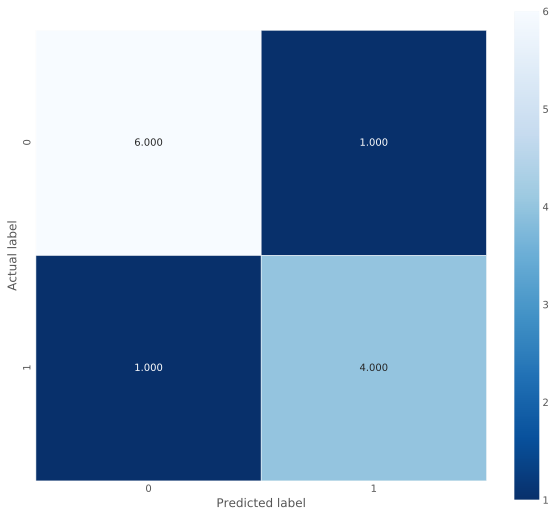

In [122]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show()

In [123]:
TP = ((y_pred == 1) & (y_test) == 1).sum()
TP

4

In [124]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

In [125]:
precision = TP / (TP + FP)
precision

0.8

In [126]:
from sklearn.metrics import recall_score

recall_score(y_test, y_pred)

0.8

In [127]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.8000000000000002

In [128]:
y_pred_proba = y_pred_proba[:, 1]

print(y_pred_proba[:5])

[0.17008627 0.63117679 0.18600689 0.96246726 0.92314253]


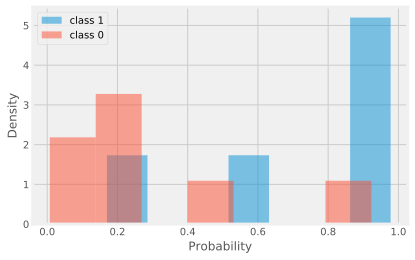

In [129]:
plt.hist(y_pred_proba[y_test == 1], bins=7, density=True, label='class 1', alpha=0.5)
plt.hist(y_pred_proba[y_test == 0], bins=7, density=True, label='class 0', alpha=0.5)

plt.xlabel("Probability")
plt.ylabel("Density")

plt.legend()

In [130]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

In [131]:
th = thresholds[6]
th

0.1700862671097189

In [132]:
print(fpr[6])
print(tpr[6])

0.7142857142857143
1.0


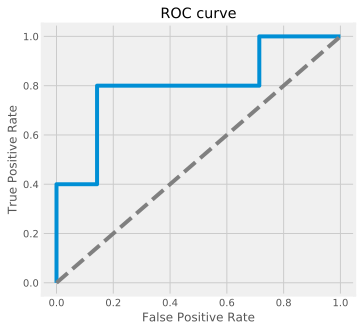

In [133]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

In [134]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_proba)

0.7999999999999999

Площадь под кривой равна 0,8 (можно считать при округлении), что поучили хорошую модель класиификации

Теперь посмотрим какие коэффициенты подобрала наша модель на этапе обучения. Визуализируем то, какой вклад вносит каждый из этих коэффициентов. Может изменение количества параметров (точнее из уменьшение) приведет к улучшению модели. 

In [135]:
lr.intercept_

array([-0.92985964])

In [136]:
lr.coef_

array([[-0.71871575,  0.25431567,  0.39275366, -0.21861032,  1.25185763,
         0.63428502,  0.41537154,  0.05097917, -1.01491918, -0.12945126,
         0.27974869, -0.37249384,  0.29542326, -0.4943899 , -0.00543964,
        -0.95871163,  0.26946149,  0.45623445, -0.37903961, -0.47429275,
        -0.19030157,  0.25947787,  0.64712837,  0.12946393,  0.18445648,
        -0.41211719,  0.13866594]])

In [137]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 12, 8

%matplotlib inline

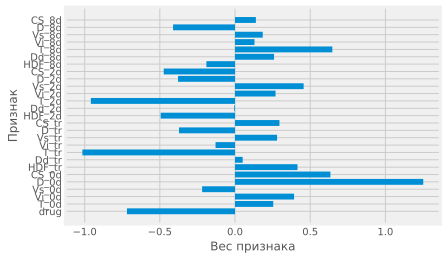

In [138]:
plt.barh(feature, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

Попробуем обучить модель, используя лишь признаки, вес которых достаточно отличается от 0, и посмотрим, как это отразится на качестве модели. Начнем с веса признаков более 0,3.

In [149]:
important_features = [
    feature
    for feature, weight in zip(feature, lr.coef_.flatten())
    if np.abs(weight) > 0.3
]

print(important_features)

['drug', 'Vi_0d', 'Vs_0d', 'D_0d', 'CS_0d', 'HDF_tr', 'Dd_tr', 'T_tr', 'Vi_tr', 'Vs_tr', 'D_tr', 'CS_tr', 'HDF_2d']


In [150]:
lr.fit(
    X_train.loc[:, important_features],
    y_train
)

y_pred = lr.predict(X_test.loc[:, important_features])

mse2 = mean_squared_error(y_test, y_pred)


print("mse до: {}".format(mse1))
print("mse после: {}".format(mse2))


mse до: 0.16666666666666666
mse после: 0.4166666666666667


Ошибка увеличилась, что не есть хорошо. Поэтому смысла убирать число переменных нет. Все остается как есть.

Итак, полученная логистическая модель имеет следующие характеристики: точность(accuracy) равную 83% и AUC = 0,79(9), что достаточно не плохо.